# K-means Clustering in Crypto Price Prediction

## Install and Import Packages

In [1]:
#! pip install yfinance pandas numpy matplotlib
#! pip install pandas_ta

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
from sklearn import preprocessing, cluster
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

## Get ETH Data

In this section, we load ETH data in 5 years and convery it to `DataFrame`, which is a better format for machine learninig

In [3]:
eth = yf.Ticker("ETH-USD")
# eth.info
eth = eth.history(period="5y")
print(eth)

                                  Open         High          Low        Close  \
Date                                                                            
2019-06-05 00:00:00+00:00   241.497040   248.138138   239.983459   247.051010   
2019-06-06 00:00:00+00:00   246.925247   249.944504   238.501114   249.474335   
2019-06-07 00:00:00+00:00   249.335281   254.352295   246.597900   250.930359   
2019-06-08 00:00:00+00:00   251.249313   252.377396   243.229111   245.738098   
2019-06-09 00:00:00+00:00   245.540482   245.972824   229.257431   233.086700   
...                                ...          ...          ...          ...   
2024-06-01 00:00:00+00:00  3759.884277  3829.294678  3749.840088  3813.198975   
2024-06-02 00:00:00+00:00  3813.275635  3834.911865  3752.414551  3780.895996   
2024-06-03 00:00:00+00:00  3780.854248  3848.603027  3758.919922  3766.389160   
2024-06-04 00:00:00+00:00  3766.476318  3831.364990  3738.134277  3812.515869   
2024-06-05 00:00:00+00:00  3

In [4]:
df = pd.DataFrame(eth)
df = df.drop('Dividends', axis=1).drop('Stock Splits', axis=1)
df.columns = df.columns.str.lower()
df.head()

,open,high,low,close,volume
Date,,,,,
2019-06-05 00:00:00+00:00,241.497040,248.138138,239.983459,247.051010,8548917062
2019-06-06 00:00:00+00:00,246.925247,249.944504,238.501114,249.474335,8265146806
2019-06-07 00:00:00+00:00,249.335281,254.352295,246.597900,250.930359,8379534528
2019-06-08 00:00:00+00:00,251.249313,252.377396,243.229111,245.738098,7225996863
2019-06-09 00:00:00+00:00,245.540482,245.972824,229.257431,233.086700,7566421456


## Calculate Features

- Garman-Klass Volatility
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volumn


In [5]:
# Garman-Klass Volatility
df['garman_klass_vol'] = (np.log(df['high']) - np.log(df['low']))**2/2 - \
  (2*np.log(2)-1) * (np.log(df['close'])-np.log(df['open']))**2

# RSI
df['rsi'] = ta.rsi(close=df['close'], length=20)

# Bollinger Bands
df['bb_low'] = ta.bbands(close=np.log(df['close']), length=20).iloc[:,0]
df['bb_mid'] = ta.bbands(close=np.log(df['close']), length=20).iloc[:,1]
df['bb_high'] = ta.bbands(close=np.log(df['close']), length=20).iloc[:,2]

# ATR
df['atr'] = ta.atr(high=df['high'], low=df['low'], close=df['close'], length=14)

# MACD
df['macd'] = ta.macd(close=df['close'], length=20).iloc[:, 0]

# Dollar Volumn
df['dolar_volumn'] = df['close']*df['volume']

df

,open,high,low,close,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dolar_volumn
Date,,,,,,,,,,,,,
2019-06-05 00:00:00+00:00,241.497040,248.138138,239.983459,247.051010,8548917062,0.000359,NaN,NaN,NaN,NaN,NaN,NaN,2.112019e+12
2019-06-06 00:00:00+00:00,246.925247,249.944504,238.501114,249.474335,8265146806,0.001057,NaN,NaN,NaN,NaN,NaN,NaN,2.061942e+12
2019-06-07 00:00:00+00:00,249.335281,254.352295,246.597900,250.930359,8379534528,0.000464,NaN,NaN,NaN,NaN,NaN,NaN,2.102680e+12
2019-06-08 00:00:00+00:00,251.249313,252.377396,243.229111,245.738098,7225996863,0.000492,NaN,NaN,NaN,NaN,NaN,NaN,1.775703e+12
2019-06-09 00:00:00+00:00,245.540482,245.972824,229.257431,233.086700,7566421456,0.001430,NaN,NaN,NaN,NaN,NaN,NaN,1.763632e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01 00:00:00+00:00,3759.884277,3829.294678,3749.840088,3813.198975,8661024535,0.000143,63.104509,7.938504,8.157346,8.376187,157.511839,182.251428,3.302621e+13
2024-06-02 00:00:00+00:00,3813.275635,3834.911865,3752.414551,3780.895996,11126903059,0.000208,61.731752,7.962589,8.169764,8.376939,152.153659,175.270143,4.206966e+13
2024-06-03 00:00:00+00:00,3780.854248,3848.603027,3758.919922,3766.389160,14082454300,0.000272,61.103397,7.996834,8.183161,8.369487,147.691476,166.645854,5.304000e+13


## Drop missing data

In [6]:
df.dropna(axis=0, inplace=True)
df

,open,high,low,close,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dolar_volumn
Date,,,,,,,,,,,,,
2019-06-30 00:00:00+00:00,319.584045,322.789581,290.695984,290.695984,10303111000,0.002016,54.293858,5.482927,5.655634,5.828341,21.431825,22.476711,2.995073e+12
2019-07-01 00:00:00+00:00,290.268494,301.026154,280.022827,293.641113,10292223948,0.002564,55.084244,5.506155,5.664530,5.822904,21.396002,20.311933,3.022220e+12
2019-07-02 00:00:00+00:00,293.537262,295.655853,272.602570,291.596436,10618413952,0.003278,54.396804,5.518542,5.670091,5.821640,21.532888,18.221299,3.096292e+12
2019-07-03 00:00:00+00:00,291.764618,303.342041,291.401642,303.099976,9926711979,0.000245,57.535279,5.537141,5.678502,5.819863,20.749332,17.293349,3.008786e+12
2019-07-04 00:00:00+00:00,303.025085,303.961151,282.765747,284.523224,8403513106,0.001079,51.509348,5.548099,5.682229,5.816359,20.785399,14.887341,2.390995e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01 00:00:00+00:00,3759.884277,3829.294678,3749.840088,3813.198975,8661024535,0.000143,63.104509,7.938504,8.157346,8.376187,157.511839,182.251428,3.302621e+13
2024-06-02 00:00:00+00:00,3813.275635,3834.911865,3752.414551,3780.895996,11126903059,0.000208,61.731752,7.962589,8.169764,8.376939,152.153659,175.270143,4.206966e+13
2024-06-03 00:00:00+00:00,3780.854248,3848.603027,3758.919922,3766.389160,14082454300,0.000272,61.103397,7.996834,8.183161,8.369487,147.691476,166.645854,5.304000e+13


## Normalization

In [7]:
scaler = preprocessing.MinMaxScaler()

df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df.head()

,open,high,low,close,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dolar_volumn
Date,,,,,,,,,,,,,
2019-06-30 00:00:00+00:00,0.044509,0.043296,0.042292,0.038305,0.099774,0.016622,0.488718,0.259812,0.225527,0.253860,0.033384,0.444860,0.007286
2019-07-01 00:00:00+00:00,0.038271,0.038739,0.039984,0.038931,0.099642,0.021153,0.501308,0.265820,0.228021,0.252347,0.033310,0.442078,0.007379
2019-07-02 00:00:00+00:00,0.038967,0.037614,0.038379,0.038496,0.103600,0.027059,0.490358,0.269024,0.229580,0.251995,0.033592,0.439391,0.007634
2019-07-03 00:00:00+00:00,0.038590,0.039224,0.042445,0.040943,0.095206,0.001978,0.540349,0.273835,0.231938,0.251500,0.031977,0.438198,0.007333
2019-07-04 00:00:00+00:00,0.040986,0.039353,0.040577,0.036992,0.076721,0.008874,0.444364,0.276670,0.232983,0.250525,0.032051,0.435106,0.005206


## Split data to training data and testing data

In [8]:
# Define the split date
split_date = '2022-01-01'

# Split the data
train_df = df.loc[:split_date]
test_df = df.loc[split_date:]

In [9]:
test_df.head()

,open,high,low,close,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dolar_volumn
Date,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.760191,0.765104,0.775950,0.778285,0.093379,0.000510,0.325029,0.961584,0.958493,0.954187,0.408548,0.277819,0.123885
2022-01-02 00:00:00+00:00,0.778543,0.778976,0.785699,0.791019,0.094657,0.002570,0.349947,0.961954,0.958660,0.954121,0.394620,0.285275,0.127289
2022-01-03 00:00:00+00:00,0.791361,0.778983,0.779359,0.776516,0.121347,0.004483,0.326412,0.962130,0.958720,0.954049,0.386009,0.285615,0.153457
2022-01-04 00:00:00+00:00,0.776854,0.787482,0.784832,0.783466,0.145014,0.006454,0.340737,0.961406,0.957914,0.953230,0.380264,0.290717,0.180296
2022-01-05 00:00:00+00:00,0.783856,0.780211,0.727161,0.731638,0.193926,0.032030,0.260356,0.957388,0.956375,0.954497,0.409082,0.271159,0.217801


## K-means clustering

### Training

In [10]:
# Initialize KMeans
k_means = cluster.KMeans(n_clusters=3)

# Add the cluster labels to the training DataFrame
train_df['cluster'] = k_means.fit_predict(train_df)

train_df

/opt/homebrew/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/rc/by_5fr2d2ds3vzb0s0qcn32r0000gn/T/ipykernel_96001/1365367464.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['cluster'] = k_means.fit_predict(train_df)


,open,high,low,close,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dolar_volumn,cluster
Date,,,,,,,,,,,,,,
2019-06-30 00:00:00+00:00,0.044509,0.043296,0.042292,0.038305,0.099774,0.016622,0.488718,0.259812,0.225527,0.253860,0.033384,0.444860,0.007286,1
2019-07-01 00:00:00+00:00,0.038271,0.038739,0.039984,0.038931,0.099642,0.021153,0.501308,0.265820,0.228021,0.252347,0.033310,0.442078,0.007379,1
2019-07-02 00:00:00+00:00,0.038967,0.037614,0.038379,0.038496,0.103600,0.027059,0.490358,0.269024,0.229580,0.251995,0.033592,0.439391,0.007634,1
2019-07-03 00:00:00+00:00,0.038590,0.039224,0.042445,0.040943,0.095206,0.001978,0.540349,0.273835,0.231938,0.251500,0.031977,0.438198,0.007333,1
2019-07-04 00:00:00+00:00,0.040986,0.039353,0.040577,0.036992,0.076721,0.008874,0.444364,0.276670,0.232983,0.250525,0.032051,0.435106,0.005206,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-28 00:00:00+00:00,0.835619,0.821143,0.794768,0.784920,0.184680,0.007841,0.313198,0.970972,0.963736,0.954495,0.440963,0.339661,0.223410,2
2021-12-29 00:00:00+00:00,0.784530,0.777263,0.760918,0.748259,0.165543,0.007178,0.262225,0.966614,0.961956,0.955650,0.440388,0.307318,0.193436,2
2021-12-30 00:00:00+00:00,0.749375,0.764611,0.757112,0.766407,0.131597,0.007439,0.297640,0.964596,0.961240,0.956400,0.433546,0.291964,0.162281,2


### Testing

In [11]:
# Predict clusters for the test data
test_clusters = k_means.predict(test_df)

# Add the cluster labels to the testing DataFrame
test_df['cluster'] = test_clusters

test_df

/var/folders/rc/by_5fr2d2ds3vzb0s0qcn32r0000gn/T/ipykernel_96001/2016087223.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['cluster'] = test_clusters


,open,high,low,close,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dolar_volumn,cluster
Date,,,,,,,,,,,,,,
2022-01-01 00:00:00+00:00,0.760191,0.765104,0.775950,0.778285,0.093379,0.000510,0.325029,0.961584,0.958493,0.954187,0.408548,0.277819,0.123885,2
2022-01-02 00:00:00+00:00,0.778543,0.778976,0.785699,0.791019,0.094657,0.002570,0.349947,0.961954,0.958660,0.954121,0.394620,0.285275,0.127289,2
2022-01-03 00:00:00+00:00,0.791361,0.778983,0.779359,0.776516,0.121347,0.004483,0.326412,0.962130,0.958720,0.954049,0.386009,0.285615,0.153457,2
2022-01-04 00:00:00+00:00,0.776854,0.787482,0.784832,0.783466,0.145014,0.006454,0.340737,0.961406,0.957914,0.953230,0.380264,0.290717,0.180296,2
2022-01-05 00:00:00+00:00,0.783856,0.780211,0.727161,0.731638,0.193926,0.032030,0.260356,0.957388,0.956375,0.954497,0.409082,0.271159,0.217801,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01 00:00:00+00:00,0.776540,0.777538,0.790563,0.787538,0.079846,0.001135,0.629059,0.894990,0.926885,0.963084,0.313986,0.650209,0.110705,2
2024-06-02 00:00:00+00:00,0.787901,0.778714,0.791119,0.780667,0.109771,0.001674,0.607193,0.901220,0.930367,0.963293,0.302937,0.641237,0.141849,2
2024-06-03 00:00:00+00:00,0.781002,0.781581,0.792527,0.777581,0.145639,0.002202,0.597184,0.910079,0.934122,0.961219,0.293736,0.630152,0.179628,2


### Evaluation

In [13]:
# Evaluate the clustering on the test data
silhouette_avg = silhouette_score(test_df.drop('cluster', axis=1), test_clusters)
calinski_harabasz = calinski_harabasz_score(test_df.drop('cluster', axis=1), test_clusters)
davies_bouldin = davies_bouldin_score(test_df.drop('cluster', axis=1), test_clusters)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Calinski-Harabasz Index: {calinski_harabasz}')
print(f'Davies-Bouldin Index: {davies_bouldin}')

Silhouette Score: 0.49381006376274
Calinski-Harabasz Index: 839.9685342273441
Davies-Bouldin Index: 0.7759175650195494


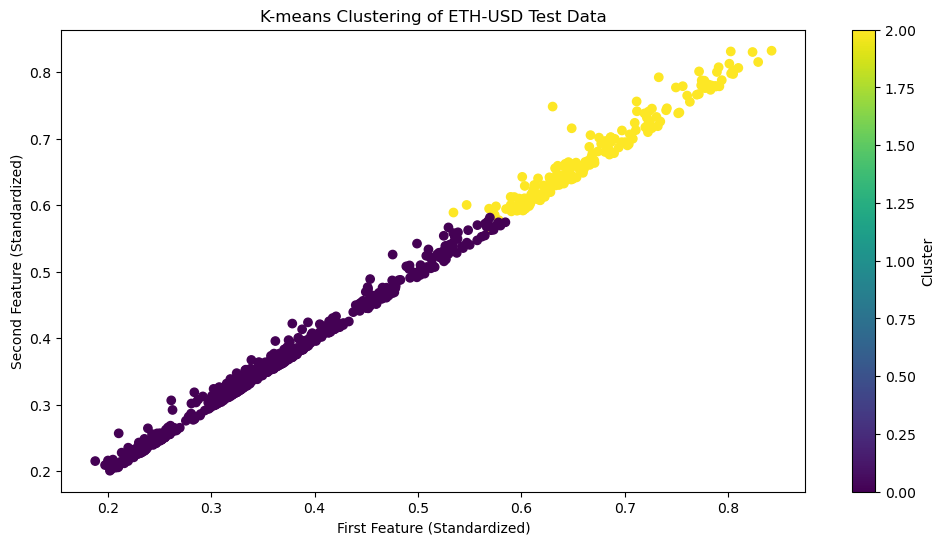

In [15]:
# Visualize the clustering result
plt.figure(figsize=(12, 6))

# Use only the first two principal components for visualization
plt.scatter(test_df.iloc[:, 0], test_df.iloc[:, 1], c=test_df['cluster'], cmap='viridis', marker='o')
plt.title('K-means Clustering of ETH-USD Test Data')
plt.xlabel('First Feature (Standardized)')
plt.ylabel('Second Feature (Standardized)')
plt.colorbar(label='Cluster')
plt.show()